<a href="https://colab.research.google.com/github/rafael2ll/california_housing/blob/master/HousingEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Estimação de Preços de Casas em Califórnia
__Dados:__ housing.csv <br>
__Objetivo__: Estimar preços de casas dados:
- Localização Geográfica
- Idade das casas
- Numero de quartos
- Numero de comodos
- População da região
- Proximidade ao mar<br>

__Variações__: Estimação de preços de produtos de mercados, variações de bolsa de valores, petróleo, etc. <br>
__Obervações__: O número de parametros usados pode variar e não ter representatividade no modelo.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Imputer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Using TensorFlow backend.


### Importando dados
Como os dados não estão padronizados é necisssário padronizar o campo de proximidade ao mar já que este possui valores númericos.

In [0]:
housing = pd.read_csv('housing.csv')

### Forma dos Dados


In [0]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [0]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


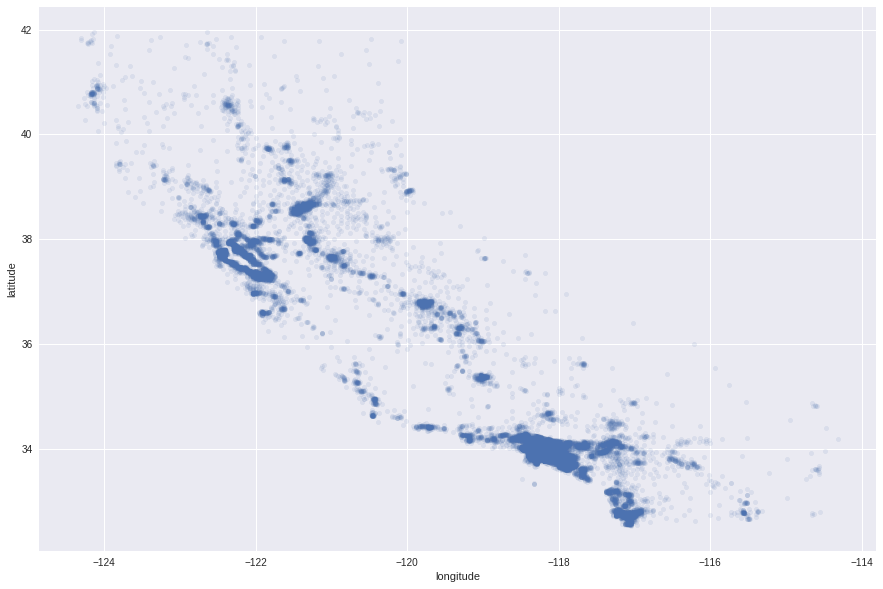

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(15,10))
plt.show()

#### Análise da correlação dos dados

In [0]:
housing.corr()["population"]

longitude             0.099773
latitude             -0.108785
housing_median_age   -0.296244
total_rooms           0.857126
total_bedrooms        0.877747
population            1.000000
households            0.907222
median_income         0.004834
median_house_value   -0.024650
Name: population, dtype: float64

In [0]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


#### Análise da correlação:
Através da tabela, verifica-se que o rendimento médio tem muita afinidade com o preço médio das casas, alémd isso

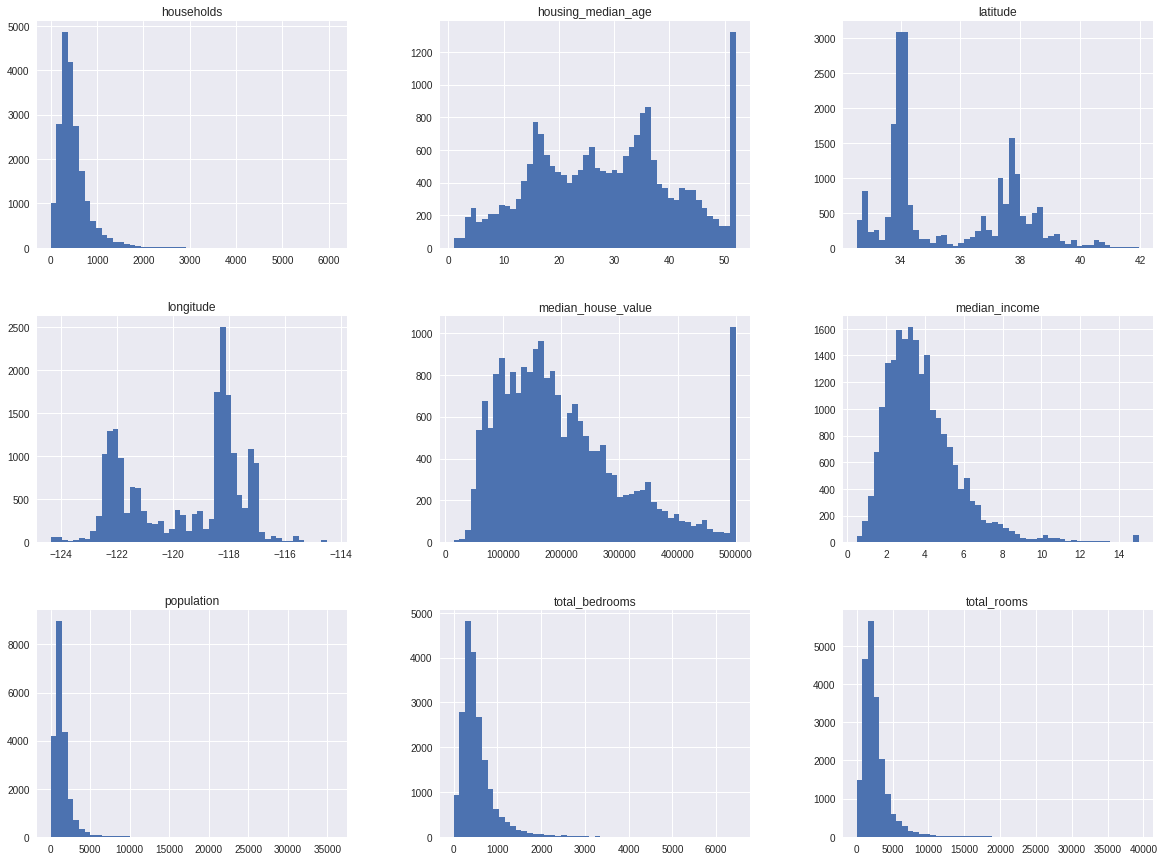

In [0]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Limpando os dados e Critérios de Split
__Obervações__: Tomando como exemplo o rendimento médio, nota-se que para a geração homogênia de dados de treino e teste também é necessário uma divisão que respeite a dispersão dos dados

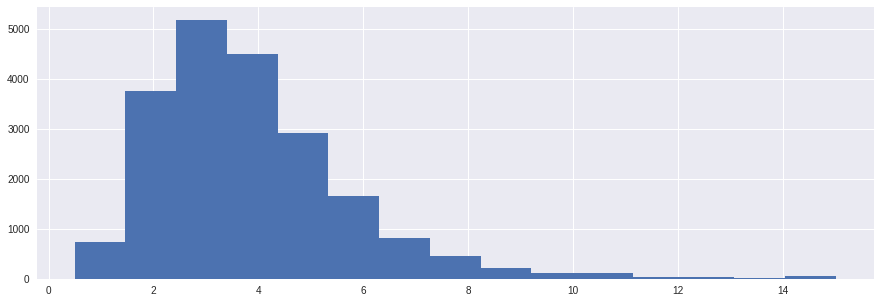

In [0]:
housing["median_income"].hist(bins=15, figsize=(15,5))
plt.show()

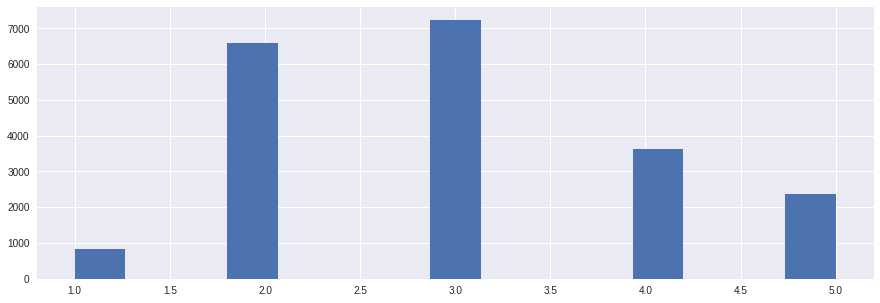

In [0]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist(bins=15, figsize=(15,5))
plt.show()

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print(housing["income_cat"].value_counts()/len(housing))
print(strat_train_set["income_cat"].value_counts()/len(strat_train_set))
print(strat_test_set["income_cat"].value_counts()/len(strat_test_set))
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)
housing.drop(["income_cat"], axis=1, inplace=True)
#housing = strat_train_set.copy()

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64
3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64
3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64


__Nota-se que a proporção dos dados se propagou para o subconjunto dos dados de treino e de teste__

### Corrigindo falhas dos dados
Pela contagem dos dados verifica-se que existem alguns campos nulos ou vazios, esses campos podem ser substituidos utilizando a classe Imputer do Scikit-learn. A abordagem utilizada substituirá os valores nulos pela média dos valores correspondentes a cada coluna.

In [0]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1) # drop labels for training set
imputer= Imputer(strategy = "median")
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)
X = imputer.transform(housing_num)
housing_transformed = pd.DataFrame(X, columns= housing_num.columns)

[-118.49     34.26     29.     2127.      435.     1166.      409.
    3.5348]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
housing_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20640 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
dtypes: float64(8)
memory usage: 1.3 MB


In [0]:
# Convertendo as strings para notações numéricas
encoder = LabelEncoder()
ocean_proximity = housing["ocean_proximity"]
ocean_proximity_encoded = encoder.fit_transform(ocean_proximity)
print("Vetor numerico: ",ocean_proximity_encoded)
ocean_tags = encoder.classes_
# Para evitar correlação de grau entre a proximidade dos números converte-se o vetor numerico em uma matriz binária
encoder= OneHotEncoder()
ocean_proximity_onehot = encoder.fit_transform(ocean_proximity_encoded.reshape(-1,1))
print("Matriz OneHot:\n", ocean_proximity_onehot.toarray()[:5])

Vetor numerico:  [3 3 3 ... 1 1 1]
Matriz OneHot:
 [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


### Explorando parametros
A adição de novos parametros pode ser um meio de aumentar a precisão do modelo posteriomente.
Campos como __comodos por habitação__ e __população por habitação__ tem coerência com o modelo.

In [0]:
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [0]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,6.98413,2.55556
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,6.23814,2.10984
2,-122.24,37.85,52,1467,190,496,177,7.2574,NEAR BAY,8.28814,2.80226
3,-122.25,37.85,52,1274,235,558,219,5.6431,NEAR BAY,5.81735,2.54795
4,-122.25,37.85,52,1627,280,565,259,3.8462,NEAR BAY,6.28185,2.18147


### Construção do Pipeline do Modelo
Todo o refinamento dos dados pode ser comprimido em uma linha de execução:
1. Seleção dos dados
2. Correção de dados falhos/inexistentes
3. Adição de novos parametros
4. Normalização dos dados
5. Encoding das strings em OneHot

In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

      
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
   
    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
housing_prepared = full_pipeline.fit_transform(housing)
print(housing.columns)
print(housing_prepared.shape)
housing_prepared[:2]

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')
(20640, 16)


array([[-1.32783522,  1.05254828,  0.98214266, -0.8048191 , -0.97247648,
        -0.9744286 , -0.97703285,  2.34476576,  0.62855945, -0.04959654,
        -1.02998783,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-1.32284391,  1.04318455, -0.60701891,  2.0458901 ,  1.35714343,
         0.86143887,  1.66996103,  2.33223796,  0.32704136, -0.09251223,
        -0.8888972 ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ]])

### Gerando o modelo de predição
Agora que os dados já foram análisados e splitados, a criação de um modelo compatível é necessária.

#### Modelo:
Regressor Linear usando Keras <br>
Ativação: RectifictiedUnit <br>
3 Layers: 16 => 6 => 1

In [0]:
model = Sequential()
model.add(Dense(16, input_dim=16, kernel_initializer='normal', activation='relu'))
model.add(Dense(6, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history = model.fit(housing_prepared, housing_labels, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)


Train on 16512 samples, validate on 4128 samples
Epoch 1/150
16512/16512 [==============================] - 1s 31us/step - loss: 53715502109.2713 - mean_squared_error: 53715502109.2713 - mean_absolute_error: 202061.6873 - val_loss: 65644386092.4031 - val_mean_squared_error: 65644386092.4031 - val_mean_absolute_error: 225995.5575
Epoch 2/150
16512/16512 [==============================] - 0s 22us/step - loss: 53661507044.7132 - mean_squared_error: 53661507044.7132 - mean_absolute_error: 201943.7052 - val_loss: 65565978512.9922 - val_mean_squared_error: 65565978512.9922 - val_mean_absolute_error: 225850.6311
Epoch 3/150
16512/16512 [==============================] - 0s 22us/step - loss: 53449178528.7442 - mean_squared_error: 53449178528.7442 - mean_absolute_error: 201485.0020 - val_loss: 65352213603.9690 - val_mean_squared_error: 65352213603.9690 - val_mean_absolute_error: 225459.0405
Epoch 4/150
16512/16512 [==============================] - 0s 22us/step - loss: 53004490440.6822 - mean_s

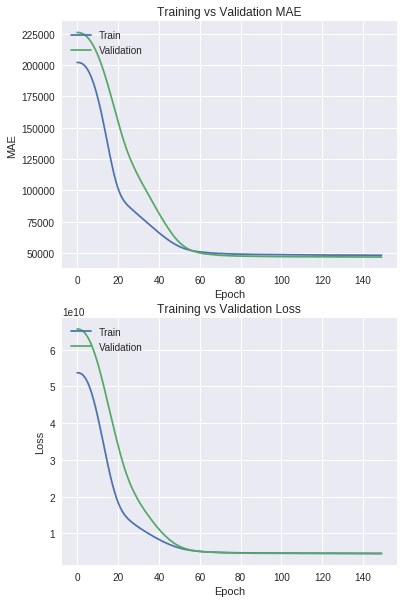

In [0]:
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return
 
plot_hist(history.history)

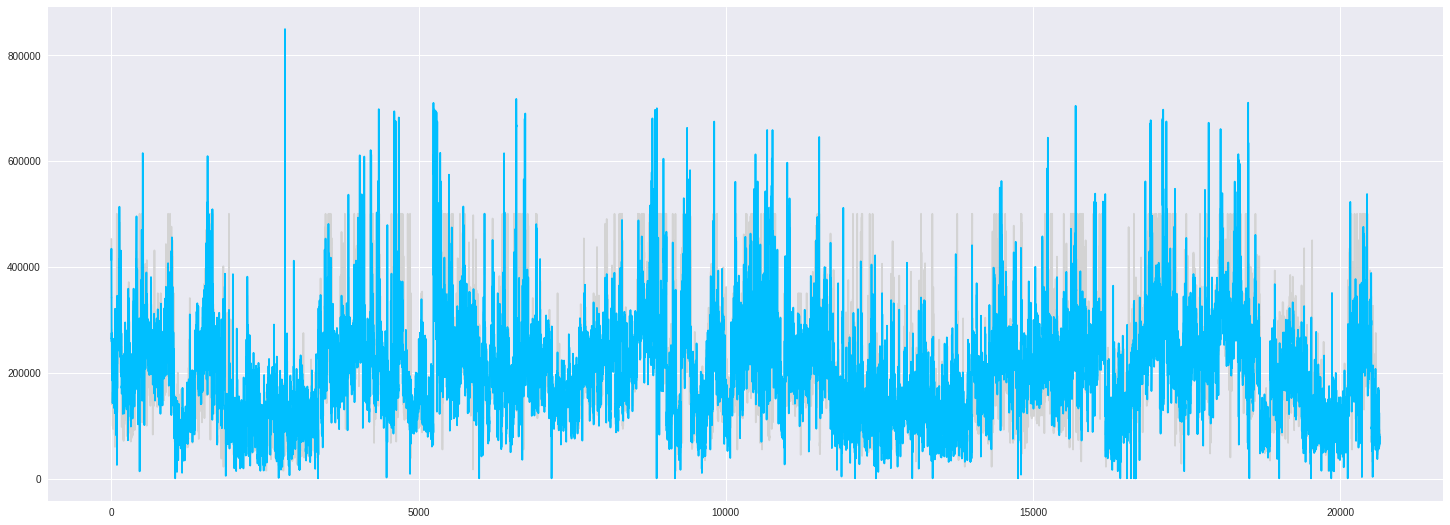

In [0]:
predicted = model.predict(housing_prepared)
dados = pd.DataFrame({'Labels' : list(housing_labels), 'Predicted': list(predicted)})
plt.subplot(211)
plt.rcParams["figure.figsize"] = [25, 20]
plt.plot([x for x in range(len(housing_labels))], housing_labels, color = 'LightGray')
plt.plot([x for x in range(len(predicted))], predicted, color = 'DeepSkyBlue')
plt.draw()
plt.show()